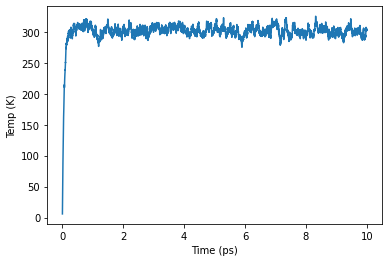

In [ ]:
import numpy as np
import matplotlib.pylab as plt

def writeOutput(filename, natoms, timestep, box, **data):
    """
    Escribe la salida en formato 'dump'.

    @filename: nombre del archivo donde se guardará la salida.
    @natoms: número de átomos en el sistema.
    @timestep: paso de tiempo actual de la simulación.
    @box: tamaño de la caja de simulación (en un formato tipo tuple).
    @data: diccionario con datos adicionales (posiciones, velocidades, etc.).
    """

    axis = ('x', 'y', 'z')  # Definir los ejes en 3D (x, y, z)

    # Abre el archivo en modo de anexar ('a')
    with open(filename, 'a') as fp:

        # Escribe el paso de tiempo en el archivo
        fp.write('ITEM: TIMESTEP\n')
        fp.write('{}\n'.format(timestep))

        # Escribe el número de átomos en el archivo
        fp.write('ITEM: NUMBER OF ATOMS\n')
        fp.write('{}\n'.format(natoms))

        # Escribe los límites de la caja de simulación
        fp.write('ITEM: BOX BOUNDS' + ' f' * len(box) + '\n')
        for box_bounds in box:
            fp.write('{} {}\n'.format(*box_bounds))

        # Añade ceros si la simulación tiene menos de 3 dimensiones
        for i in range(len(axis) - len(box)):
            fp.write('0 0\n')

        keys = list(data.keys())  # Obtiene las claves de los datos adicionales

        # Reorganiza los datos si son matrices (e.g., posiciones o velocidades)
        for key in keys:
            isMatrix = len(data[key].shape) > 1

            if isMatrix:
                _, nCols = data[key].shape

                for i in range(nCols):
                    if key == 'pos':
                        data['{}'.format(axis[i])] = data[key][:,i]
                    else:
                        data['{}_{}'.format(key,axis[i])] = data[key][:,i]

                del data[key]  # Borra el dato original, ahora se divide por componentes

        keys = data.keys()

        # Escribe las cabeceras de los átomos y sus propiedades
        fp.write('ITEM: ATOMS' + (' {}' * len(data)).format(*data) + '\n')

        output = []
        for key in keys:
            output = np.hstack((output, data[key]))

        if len(output):
            # Guarda los datos en el archivo en el formato adecuado
            np.savetxt(fp, output.reshape((natoms, len(data)), order='F'))


# Definir constantes físicas globales
Avogadro = 6.02214086e23  # Número de Avogadro
Boltzmann = 1.38064852e-23  # Constante de Boltzmann

def wallHitCheck(pos, vels, box):
    """
    Aplica condiciones de frontera reflectantes. Si una partícula
    choca contra una pared, su velocidad se invierte en esa dirección.

    @pos: posiciones atómicas (ndarray)
    @vels: velocidades atómicas (ndarray, actualizado si se detectan colisiones)
    @box: tamaño de la caja de simulación (tuple)
    """
    ndims = len(box)  # Número de dimensiones de la simulación

    for i in range(ndims):
        # Verifica si las partículas están fuera de los límites y refleja la velocidad
        vels[((pos[:,i] <= box[i][0]) | (pos[:,i] >= box[i][1])),i] *= -1

def integrate(pos, vels, forces, mass,  dt):
    """
    Integrador simple de Euler hacia adelante que avanza el sistema en el tiempo.

    @pos: posiciones atómicas (ndarray, actualizado)
    @vels: velocidades atómicas (ndarray, actualizado)
    @forces: fuerzas aplicadas a las partículas (ndarray)
    @mass: masa de las partículas (ndarray)
    @dt: paso de tiempo de la simulación (float)
    """

    pos += vels * dt  # Actualiza posiciones
    vels += forces * dt / mass[np.newaxis].T  # Actualiza velocidades

def computeForce(mass, vels, temp, relax, dt):
    """
    Calcula la fuerza de Langevin para todas las partículas.

    @mass: masa de las partículas (ndarray)
    @vels: velocidades de las partículas (ndarray)
    @temp: temperatura (float)
    @relax: constante de relajación del termostato (float)
    @dt: paso de tiempo de la simulación (float)

    Retorna un ndarray con las fuerzas calculadas.
    """

    natoms, ndims = vels.shape  # Número de átomos y dimensiones

    # Cálculo del parámetro sigma para la fuerza aleatoria de Langevin
    sigma = np.sqrt(2.0 * mass * temp * Boltzmann / (relax * dt))
    noise = np.random.randn(natoms, ndims) * sigma[np.newaxis].T  # Genera ruido aleatorio

    # Calcula la fuerza de Langevin
    force = - (vels * mass[np.newaxis].T) / relax + noise

    return force

def removeCOM(pos, mass):
    """
    Elimina el movimiento del centro de masa. Esta función no se usa en este código.

    @pos: posiciones atómicas (ndarray, actualizado)
    @mass: masa de las partículas (ndarray)
    """
    pos -= np.dot(mass, pos) / mass.sum()  # Corrige la posición respecto al centro de masa

def run(**args):
    """
    Función principal que resuelve las ecuaciones de Langevin para un sistema de natoms
    usando un esquema de Euler hacia adelante. Retorna una lista con el tiempo y la temperatura.

    @natoms (int): número de partículas
    @temp (float): temperatura (en Kelvin)
    @mass (float): masa de las partículas (en Kg)
    @relax (float): constante de relajación (en segundos)
    @dt (float): paso de tiempo de la simulación (s)
    @nsteps (int): número total de pasos que realiza el solucionador
    @box (tuple): tamaño de la caja de simulación (en metros) con dimensiones de tamaño 2
                  por ejemplo, box = ((-1e-9, 1e-9), (-1e-9, 1e-9)) define un cuadrado 2D
    @ofname (string): nombre del archivo para escribir la salida
    @freq (int): frecuencia para escribir la salida cada 'freq' pasos
    @radius (float): radio de las partículas (para visualización)

    Retorna una lista (de tamaño nsteps x 2) que contiene el tiempo y la temperatura.
    """

    # Extracción de los parámetros necesarios para la simulación
    natoms, box, dt, temp = args['natoms'], args['box'], args['dt'], args['temp']
    mass, relax, nsteps   = args['mass'], args['relax'], args['steps']
    ofname, freq, radius = args['ofname'], args['freq'], args['radius']

    dim = len(box)  # Número de dimensiones de la simulación
    pos = np.random.rand(natoms,dim)  # Inicializa posiciones aleatorias dentro de la caja

    for i in range(dim):
        pos[:,i] = box[i][0] + (box[i][1] -  box[i][0]) * pos[:,i]  # Ajusta posiciones dentro de los límites de la caja

    vels = np.random.rand(natoms,dim)  # Inicializa velocidades aleatorias
    mass = np.ones(natoms) * mass / Avogadro  # Ajusta la masa de las partículas
    radius = np.ones(natoms) * radius  # Define el radio de las partículas
    step = 0

    output = []  # Inicializa la lista para almacenar los resultados

    while step <= nsteps:  # Ciclo principal de simulación

        step += 1

        # Calcula todas las fuerzas sobre las partículas
        forces = computeForce(mass, vels, temp, relax, dt)

        # Mueve el sistema en el tiempo
        integrate(pos, vels, forces, mass, dt)

        # Verifica si alguna partícula ha chocado con las paredes de la caja
        wallHitCheck(pos,vels,box)

        # Calcula la temperatura instantánea
        ins_temp = np.sum(np.dot(mass, (vels - vels.mean(axis=0))**2)) / (Boltzmann * dim * natoms)
        output.append([step * dt, ins_temp])

        if not step % freq:  # Escribe los resultados en el archivo de salida cada 'freq' pasos
            writeOutput(ofname, natoms, step, box, radius=radius, pos=pos, v=vels)

    return np.array(output)  # Retorna los resultados en forma de ndarray

if __name__ == '__main__':

    # Parámetros de la simulación
    params = {
        'natoms': 1000,  # Número de partículas
        'temp': 300,  # Temperatura en Kelvin
        'mass': 0.001,  # Masa de las partículas en Kg
        'radius': 120e-12,  # Radio de las partículas en metros
        'relax': 1e-13,  # Constante de relajación en segundos
        'dt': 1e-15,  # Paso de tiempo en segundos
        'steps': 10000,  # Número total de pasos de simulación
        'freq': 100,  # Frecuencia para escribir los datos de salida
        'box': ((0, 1e-8), (0, 1e-8), (0, 1e-8)),  # Tamaño de la caja de simulación en metros (3D)
        'ofname': 'traj-hydrogen-3D.dump'  # Nombre del archivo de salida
        }

    # Ejecuta la simulación
    output = run(**params)

    # Grafica los resultados
    plt.plot(output[:,0] * 1e12, output[:,1])
    plt.xlabel('Tiempo (ps)')
    plt.ylabel('Temperatura (K)')
    plt.show()
